In [4]:
# -*- coding: utf-8 -*-
"""
Created on Fri Jun 15 14:21:59 2018
This Language detector model detects seven languages that largely use the Latin
script(English, German, French, Italian, Spanish, Portuguese, Dutch). It is 
implemented using a Multiclass Random Forest text classifier using words, 
bigrams, and trigrams as features. To optimize training and testing performance
by reducing number of features,a corpus of 300,000 sentences for each language 
is leveraged from Leipzig Corpus and the 50 most frequent words, bigrams, and 
trigrams are shortlisted as features. The dataframe creation is slightly 
complicated, but it is highly vectorized to speed up performance. All train and
test datapoints are then represented in the reduced feature-space. A model 
trained on 5,000 sentences from each language takes less than 2 minutes to 
train, and performs at 98% accuracy. 
To replicate the environment, place the following data files sourced from 
http://wortschatz.uni-leipzig.de/en/download in a directory, and assign that to 
'dirname'
1. deu_mixed-typical_2011_300K-sentences.txt
2. eng_news_2005_300K-sentences.txt
3. fra_mixed_2009_300K-sentences.txt
4. ita_mixed-typical_2017_300K-sentences.txt
5. nld_mixed_2012_300K-sentences.txt
6. por_newscrawl_2011_300K-sentences.txt
7. spa_news_2006_300K-sentences.txt

Novel ideas - shortlisting features based on frequency to quicken random forest performance

Scope for improvement -  Need to prune feature space to further remove  
redundancies. One approach could be through the use of maximal substrings.
For eg - the trigram ' a ' will be a substring of ' a' always and can be removed

@author: Kiran Ramnath
Applicant ID - 201806110737_RamnathKiran
"""
import pandas as pd
from string import punctuation
import time
import numpy as np
import gc
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from gensim.corpora import Dictionary
from gensim.matutils import sparse2full

In [5]:
dirname='C:/Personal/R/UKP/Data/'

In [6]:
#%% Read tab separated files

def read_file(path):

    t=pd.read_fwf(path, delimiter="\t",header=None)
    t[0]=t[0].apply(lambda row: row.split("\t")[1])

    return t

In [7]:
#%% function that takes text and n-gram length as input, returns list of tuples of the format [(ngram_count, n-gram)]    
    
def max_ngram_extracter(sent,num_of_chars):
    
    ngram_vectorizer=CountVectorizer(input="content",analyzer="char_wb",ngram_range=(num_of_chars,num_of_chars))
    ngrams=ngram_vectorizer.fit_transform(sent)
    
    count_values=ngrams.toarray().sum(axis=0)
    vocab = ngram_vectorizer.vocabulary_
    counts = sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True)
    counts = [(c[1],c[0]) for c in counts]
    
    return counts

In [8]:
#%% function that takes text as input, returns list of tuples of the format [(word_count, word)]
    
def max_word_extracter(sent):

    word_vectorizer=CountVectorizer(input="content",analyzer="word", ngram_range=(1,1))
    ngrams=word_vectorizer.fit_transform(sent)
    
    count_values=ngrams.toarray().sum(axis=0)
    vocab = word_vectorizer.vocabulary_
    counts = sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True)
    counts = [(c[1],c[0]) for c in counts]
    
    return counts    

In [9]:
#%% function that reads all csv files (one per language). Contains language column that will be used as training class 
#   for the classification algorithm. Returns train and test dataframess, all tuples of bigrams, trigrams, count_words    

def language_df_creator(filename,language):    

    df=read_file(dirname+filename)
    df['language']=language
    
    #creating train-test split
    df_train, df_test = train_test_split(df, test_size=1000, random_state=42)
    
    #merging all text from train_df in one list to find most frequent words,bigrams and trigrams
    
    lang_txt=df_train.groupby('language')[0].apply(lambda row: (" ").join(row))
    lang_count_bigrams=max_ngram_extracter(lang_txt,2)
    lang_count_trigrams=max_ngram_extracter(lang_txt,3)
    lang_count_words=max_word_extracter(lang_txt)
    
    return df_train, df_test, lang_count_bigrams, lang_count_trigrams, lang_count_words

In [10]:
time_start=time.time()

#%% Features, training data, test data for English
english_df_train, english_df_test, english_count_bigrams, english_count_trigrams, english_count_words = language_df_creator("eng_news_2005_300K-sentences.txt","english")

#%% Features, training data, test data for German
german_df_train, german_df_test, german_count_bigrams, german_count_trigrams, german_count_words=language_df_creator("deu_mixed-typical_2011_300K-sentences.txt","german")

#%% Features, training data, test data for Italian
italian_df_train, italian_df_test, italian_count_bigrams, italian_count_trigrams, italian_count_words=language_df_creator("ita_mixed-typical_2017_300K-sentences.txt","italian")

#%% Features, training data, test data for Spanish
spanish_df_train, spanish_df_test, spanish_count_bigrams, spanish_count_trigrams, spanish_count_words=language_df_creator("spa_news_2006_300K-sentences.txt","spanish")

#%% Features, training data, test data for Portuguee
portuguese_df_train, portuguese_df_test, portuguese_count_bigrams, portuguese_count_trigrams, portuguese_count_words=language_df_creator("por_newscrawl_2011_300K-sentences.txt","portuguese")

#%% Features, training data, test data for French
french_df_train, french_df_test, french_count_bigrams, french_count_trigrams, french_count_words = language_df_creator("fra_mixed_2009_300K-sentences.txt","french")

#%% Features, training data, test data for Dutch
dutch_df_train, dutch_df_test, dutch_count_bigrams, dutch_count_trigrams, dutch_count_words=language_df_creator("nld_mixed_2012_300K-sentences.txt","dutch")

time_taken_read=time.time()-time_start

In [20]:
#%% creating unique feature-list containing 50 most frequent words, bigrams, trigrams for all languages

features=set([f[0] for f in english_count_bigrams[0:50]
                        +english_count_words[0:50]
                        +english_count_trigrams[0:50]
                        +german_count_bigrams[0:50]
                        +german_count_trigrams[0:50]
                        +german_count_words[0:50]
                        +italian_count_bigrams[0:50]
                        +italian_count_trigrams[0:50]
                        +italian_count_words[0:50]
                        +spanish_count_bigrams[0:50]
                        +spanish_count_trigrams[0:50]
                        +spanish_count_words[0:50]
                        +portuguese_count_bigrams[0:50]
                        +portuguese_count_trigrams[0:50]
                        +portuguese_count_words[0:50]
                        +french_count_bigrams[0:50]
                        +french_count_trigrams[0:50]
                        +french_count_words[0:50]
                        +dutch_count_bigrams[0:50]
                        +dutch_count_trigrams[0:50]
                        +dutch_count_words[0:50]
                        if f[0] not in punctuation]) 

In [21]:
#%% Using Gensim's dictionary object to store features. This allows us to 
    #create dense vectors for all datapoints efficiently, speeding up data creation
    
dct=Dictionary([list(features)])

#re-assigning features because gensim creates dictionary in alphabetical order
features=list(dct.token2id.keys())

In [22]:
#%% 5,000 sentences from each each language is used to train the classification model 

english_df_train_frac=english_df_train.sample(n=5000,random_state=42)
german_df_train_frac=german_df_train.sample(n=5000,random_state=42)
italian_df_train_frac=italian_df_train.sample(n=5000,random_state=42)
spanish_df_train_frac=spanish_df_train.sample(n=5000,random_state=42)
portuguese_df_train_frac=portuguese_df_train.sample(n=5000,random_state=42)
french_df_train_frac=french_df_train.sample(n=5000,random_state=42)
dutch_df_train_frac=dutch_df_train.sample(n=5000,random_state=42)
#%%
train_df=pd.concat([english_df_train_frac,german_df_train_frac,
                    italian_df_train_frac,spanish_df_train_frac, 
                    portuguese_df_train_frac,french_df_train_frac,dutch_df_train_frac], 
                   ignore_index=True)

In [23]:
#%% create dataframe for all training sentences containing unique features as columns 

def create_dataframe_rf(df):

    df.rename(columns={0:"text"}, inplace=True)
    zero_data=np.zeros(shape=(len(df),len(features)))
    feature_df=pd.DataFrame(zero_data,index=df.index, columns=features)
    df=pd.concat([df,feature_df],axis=1)

    return df

train_df=create_dataframe_rf(train_df)
print (train_df.head())

                                                text language    a   a    al  \
0  "The Ralph Lauren restaurant is right down the...  english  0.0  0.0  0.0   
1  I think not everybody understands this coopera...  english  0.0  0.0  0.0   
2  After a long walk you may like to sit and eat ...  english  0.0  0.0  0.0   
3  All but one has moved up into the big track, m...  english  0.0  0.0  0.0   
4  Once a new district office is finished, offici...  english  0.0  0.0  0.0   

    an   au    b   be    c ...   ã¨    ã©  ã©    ã³  ã³   ã³n  ãµes   ã¼  \
0  0.0  0.0  0.0  0.0  0.0 ...   0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0 ...   0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0   
2  0.0  0.0  0.0  0.0  0.0 ...   0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0   
3  0.0  0.0  0.0  0.0  0.0 ...   0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0   
4  0.0  0.0  0.0  0.0  0.0 ...   0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0   

   ã¼ber   ãˆ  
0    0.0  0.0  
1    0.0  0.0  
2    0.0  0.0 

In [24]:
#%% Free up memory, perform garbage collection
del german_df_train, french_df_train, english_df_train, dutch_df_train, spanish_df_train, italian_df_train
gc.collect()

2543

In [25]:
#%% label encoder applies integer labels to all classes

languages=['english','dutch','german','italian','spanish','portuguese','french']

#create flags on the basis of language
le = preprocessing.LabelEncoder()    
le.fit(languages)

LabelEncoder()

In [27]:
#%% create features for all sentences, find and populate shortlisted feature columns
#   This is the most time consuming step. 

def feature_creator(df):    

    #Using Gensim utility function to populate training dataset
    bag_of_words=df['text'].apply(lambda row: sparse2full([(dct.token2id[m[0]],m[1]) for m in max_word_extracter([row]) if m[0] in dct.token2id], length=len(features)))
    bag_of_words=np.array(bag_of_words.tolist()).astype(int)

    bag_of_bigrams=df['text'].apply(lambda row: sparse2full([(dct.token2id[m[0]],m[1]) for m in max_ngram_extracter([row],2) if m[0] in dct.token2id], length=len(features)))        
    bag_of_bigrams=np.array(bag_of_bigrams.tolist()).astype(int)

    bag_of_trigrams=df['text'].apply(lambda row: sparse2full([(dct.token2id[m[0]],m[1]) for m in max_ngram_extracter([row],3) if m[0] in dct.token2id], length=len(features)))
    bag_of_trigrams=np.array(bag_of_trigrams.tolist()).astype(int)

    #Add matrix representation of words, bigrams, and trigrams components of all vectors
    all_features=bag_of_words+bag_of_bigrams+bag_of_trigrams
    all_features.astype(int)

    #populate train_df with all features
    all_features_df=pd.DataFrame(data=all_features, columns=features)
    df.update(all_features_df)
    
    #random forest requires integer labels, so transform text levels to integer levels
    df['flag']=le.transform(df['language'])           
    print ("Feature creation finished")
    
    return df

In [29]:
#%%
time_start=time.time()
train_df = feature_creator(train_df) 
time_taken_train_df=time.time()-time_start
print (train_df.head())

Feature creation finished
                                                text language    a   a    al  \
0  "The Ralph Lauren restaurant is right down the...  english  1.0  0.0  0.0   
1  I think not everybody understands this coopera...  english  3.0  1.0  0.0   
2  After a long walk you may like to sit and eat ...  english  4.0  1.0  0.0   
3  All but one has moved up into the big track, m...  english  7.0  0.0  1.0   
4  Once a new district office is finished, offici...  english  1.0  1.0  0.0   

    an   au    b   be    c  ...    ã©  ã©    ã³  ã³   ã³n  ãµes   ã¼  ã¼ber  \
0  0.0  0.0  1.0  0.0  0.0  ...   0.0  0.0  0.0  0.0  0.0   0.0  0.0    0.0   
1  2.0  0.0  2.0  2.0  2.0  ...   0.0  0.0  0.0  0.0  0.0   0.0  0.0    0.0   
2  2.0  0.0  0.0  0.0  0.0  ...   0.0  0.0  0.0  0.0  0.0   0.0  0.0    0.0   
3  0.0  0.0  2.0  0.0  2.0  ...   0.0  0.0  0.0  0.0  0.0   0.0  0.0    0.0   
4  0.0  0.0  2.0  2.0  0.0  ...   0.0  0.0  0.0  0.0  0.0   0.0  0.0    0.0   

    ãˆ  flag  
0  

In [30]:
def random_forest(train_df, number_of_estimators):
        
    # Random Forest Model 
    clf_rforest = RandomForestClassifier(n_estimators=number_of_estimators, random_state=1, min_samples_leaf=5, max_depth=30)
    clf_rforest.fit(train_df[features], train_df['flag'])

    # Importance of features
    rforest_importances = clf_rforest.feature_importances_
    rforest_importances = dict(zip(features,rforest_importances))

    return clf_rforest, rforest_importances

time_start=time.time()
clf_rforest, rforest_importances=random_forest(train_df, 500)
time_taken_rf=time.time()-time_start
print (rforest_importances)

{' a': 0.0021398472812025997, ' a ': 0.0019054297086754162, ' al': 9.824067500600951e-05, ' an': 0.0008189983634544314, ' au': 0.0003189743698450363, ' b': 0.0004865264561661193, ' be': 0.00022417309506532002, ' c': 0.009599233580994857, ' ca': 0.00013468720795105485, ' co': 0.0015268322216280574, ' d': 0.003205285213865115, " d'": 0.0005405038861892551, ' da': 0.0005805063605903156, ' de': 0.0040286467089258775, ' di': 0.0004691687409931829, ' do': 0.0003412779137978535, ' e': 0.0062587053644934535, ' e ': 0.0023501166135839534, ' ee': 0.00587413487669972, ' ei': 0.002543128151634293, ' el': 0.00896703720783127, ' em': 0.00037410368561758634, ' en': 0.0033672323159025957, ' er': 6.222689526763086e-05, ' es': 0.0014779260224022644, ' et': 0.003282367626769566, ' f': 0.0006156806617703851, ' fo': 0.0002466263794185977, ' g': 0.00024519177139714176, ' ge': 0.00042043362607790393, ' h': 0.002345567222132579, ' ha': 0.0005076985764624765, ' he': 0.003578603806513755, ' i': 0.00063402322735

In [31]:
#%% create test set containing 1000 sentences from each language

test_df=pd.concat([english_df_test,german_df_test,italian_df_test,spanish_df_test,
                        portuguese_df_test,french_df_test,dutch_df_test], ignore_index=True)

In [32]:
# Process of creating features for scoring dataset
def scoring_df(test_df):

    test_df=create_dataframe_rf(test_df)
    test_df=feature_creator(test_df)

    return test_df

In [33]:
#%%
time_start=time.time()
test_df=scoring_df(test_df)
time_taken_test_df=time.time()-time_start

Feature creation finished


In [34]:
#%%
time_start=time.time()
test_df['prediction']=le.inverse_transform(clf_rforest.predict(test_df[features]))
time_taken_score=time.time()-time_start    

C:\Tools\Anaconda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [35]:
#%% Print performance metrics like precision, recall, f-1 score

print(classification_report(test_df['language'],test_df['prediction'],target_names=languages))

             precision    recall  f1-score   support

    english       0.99      0.98      0.98      1000
      dutch       0.99      0.98      0.99      1000
     german       0.99      0.97      0.98      1000
    italian       0.96      0.98      0.97      1000
    spanish       0.92      0.99      0.96      1000
 portuguese       0.98      0.97      0.98      1000
     french       1.00      0.96      0.98      1000

avg / total       0.98      0.98      0.98      7000



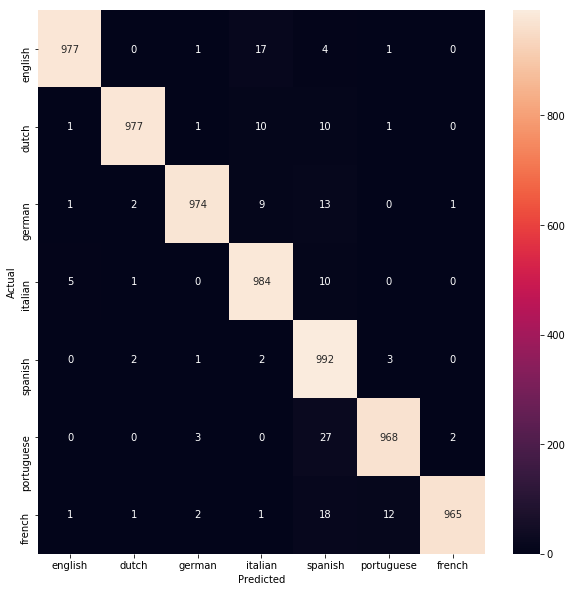

In [36]:
#%% Print confusion matrix

conf_mat = confusion_matrix(test_df['language'],test_df['prediction'])
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=languages, yticklabels=languages)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [37]:
print ("Time taken to read files and rank features based on frequency is "+str(int(time_taken_read))+" seconds")
print ("Time taken to create training input dataframe is "+str(int(time_taken_train_df))+" seconds")
print ("Time taken to create random forest model is "+str(int(time_taken_rf))+" seconds")
print ("Time taken to create test dataframe is "+str(int(time_taken_test_df))+" seconds")
print ("Time taken to predict test classes is "+str(int(time_taken_score))+" seconds")

Time taken to read files and rank features based on frequency is 338 seconds
Time taken to create training input dataframe is 114 seconds
Time taken to create random forest model is 54 seconds
Time taken to create test dataframe is 28 seconds
Time taken to predict test classes is 1 seconds
